In [3]:
import sys
print(f'Interpreter dir: {sys.executable}')
import os

if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    
print(f'Working dir: {os.getcwd()}')
%load_ext autoreload
%autoreload 2

Interpreter dir: /Users/jsg/Documents/GitHub/water_hackathlon/.venv_waterhack/bin/python3
Working dir: /Users/jsg/Documents/GitHub/water_hackathlon


In [4]:
import pprint
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 100)
from pandas_profiling import ProfileReport
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,KFold,cross_val_score,ShuffleSplit,StratifiedKFold
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix,classification_report
import matplotlib.pyplot as plt

from scipy.stats import randint,uniform
import lightgbm as lgb

from waterhack.visualize import time_vs_y
from waterhack.utils import find_col
from waterhack.utils import series_to_supervised

In [5]:
from ortools.linear_solver import pywraplp

# Run optimization as Mazzolani

---

The parameters/inuts are:
- $K$: ratio bwith Ln.
- $V_d$ or `vol_day`: average day volume at day $d$
- $V_{n,d}$ or `vol_nf`: average night flow volume at day $d$

The only variable in the original equation is then $L_n$, representing the night leakage, constant along the days. This is an assumption of the paper, which we could extend in the future.

The main formula is:

$$K \cdot V_d - K \cdot L_n + L_n = V_{n,d}$$

The first term represents the "real" day volume. The second term represents the real day leakage, plus the third term which is the leakage.

Because the system of equation (in practice) has no solution, we find the best one as follows.

Minimize $ \sum_d ( \epsilon^+_d + \epsilon^-_d)$

subject to $K \cdot V_d +(1- K) \cdot L_n  = V_{n,d} + \epsilon^+_d - \epsilon^-_d$

The constraints can be written as:

$ L_n (1- K ) - \epsilon^+_d + \epsilon^-_d = V_{n,d}  - K \cdot V_d$

Where the variables $L_n$, $\epsilon^+_d$ and $\epsilon^-_d$ are $>=0$.

---


In [112]:
def get_ln(vol_day, vol_nf, K):
    return (vol_nf - K*vol_day)/(1-K)


def optimizeK(vol_day,vol_nf,K, debug=False):
    """Find the optimal value of leakage
    """
    # Number of data points
    N = len(vol_day)
    assert len(vol_day) == len(vol_nf), "Length of volumes do not match"
    
    # Define linear solver
    solver = pywraplp.Solver.CreateSolver('linear_programming', 'GLOP')
    
    # Create variables to be optimized
    Ln = solver.NumVar(-solver.infinity(),solver.infinity(), 'Ln')
    
    eps_pos, eps_neg = [-999]*N, [-999]*N
    for i in range(N):
        eps_pos[i] = solver.NumVar(0, solver.infinity(), f'eps_pos_{i}')
        eps_neg[i] = solver.NumVar(0,solver.infinity(), f'eps_neg_{i}')
    
    # Constraints
    constraints = [0] * N
    for i in range(N):
        c_term =  vol_nf[i] - K * vol_day[i]
        constraints[i] = solver.Constraint(c_term, c_term)
        constraints[i].SetCoefficient(eps_pos[i], -1)
        constraints[i].SetCoefficient(eps_neg[i], 1)
        constraints[i].SetCoefficient(Ln, (1-K))

    # Objective function: sum(eps)
    objective = solver.Objective()
    for i in range(N):              
        objective.SetCoefficient(eps_pos[i], 1)
        objective.SetCoefficient(eps_neg[i], 1)
    objective.SetMinimization()

    # Solve the system.
    solved = solver.Solve()
    if solved == solver.OPTIMAL:
        result_status = 'optimal'
    elif solved == solver.INFEASIBLE:
        result_status = 'No solution found'
    elif solved == solver.POSSIBLE_OVERFLOW:
        result_status = 'Integer overflow'
    else:
        result_status = solver.POSSIBLE_OVERFLOW

    # [START print_solution]
    # The value of each variable in the solution.
    eps_pos_sol = [-999]*N
    eps_neg_sol = [-999]*N
    for i in range(N):
        eps_pos_sol[i] = eps_pos[i].solution_value()
        eps_neg_sol[i] = eps_pos[i].solution_value()
    
    # The objective value of the solution.
    obj_value = np.sum(eps_pos_sol) + np.sum(eps_neg_sol)
    
    if debug:
        print('MODEL FORMULATION:\n-----')
        print(solver.ExportModelAsLpFormat(False))
        print('----')
        
    
    return {'Ln':Ln.solution_value(),
            'eps_pos_sol' : eps_pos_sol,
            'eps_neg_sol': eps_pos_sol,
            'obj_value':obj_value,
            'result_status':result_status,
            'n_var': solver.NumVariables(),
            'n_const':solver.NumConstraints()
           }

In [128]:
# vol_day = [10,20,30,20,10,30,40,60,80,30,10,13,14,15]
# vol_nf = [5,4,6,7,8,0,0,20,10,7,5,1,2,1]

vol_day = [10,20,30]
vol_nf = [1,2,3]
K=0.5
sol = optimizeK(vol_day,vol_nf,K)
pprint.pprint(sol, width=1)


{'Ln': -16.0,
 'eps_neg_sol': [0.0,
                 0.0,
                 4.0],
 'eps_pos_sol': [0.0,
                 0.0,
                 4.0],
 'n_const': 3,
 'n_var': 7,
 'obj_value': 8.0,
 'result_status': 'optimal'}


In [129]:
ln_est = []
for i in range(len(vol_day)):
    ln_est.append(get_ln(vol_day[i], vol_nf[i], K))
    print(f"Estimated daily Ln[{i}]:{ln_est[i]}")

print(f" Mean of estimated Ln: {np.mean(ln_est)}")
# Para esto no necesitabbamos hacer un problema de optimizacion! Argggg



Estimated daily Ln[0]:-8.0
Estimated daily Ln[1]:-16.0
Estimated daily Ln[2]:-24.0
 Mean of estimated Ln: -16.0


- Si fijamos el valor de $K$: el problema de buscar un $Ln$ se reduce a hacer la media, despues de despejar cada ecuacion por separado (ver codigo superior)
- En este caso, no necesitamos ningun tipo de optimizacion. Podemos:
    1. Buscar el valor de Ln analiticamente, haciendo la media
    2. Encontrar el valor de la funcion objetivo. Para cada dia: fijar el valor de Ln del paso anterior, y sumar los $\epsilon$

In [124]:
# i=0
# print(f"Reformulation:")
# print(f" Left hand side: {K*vol_day[i] +(1-  K)*sol['Ln']}")
# print(f" Right hand side: {vol_nf[i] + sol['eps_pos_sol'][i] - sol['eps_neg_sol'][i]}")

# print(f"Reformulation 2:")
# print(f" Left hand side: {(1-  K)*sol['Ln'] - sol['eps_pos_sol'][i] + sol['eps_neg_sol'][i] }")
# print(f" Right hand side: {vol_nf[i]- K*vol_day[i]}")

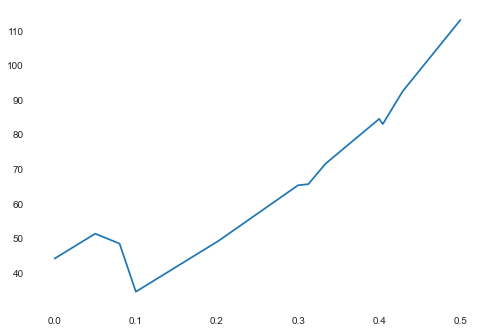

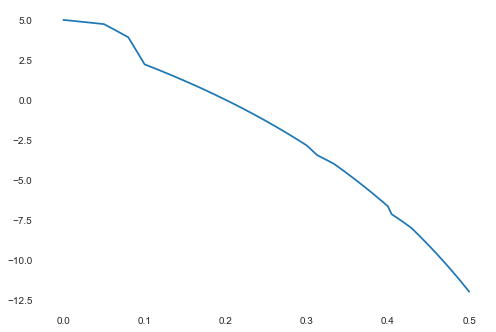

In [127]:
vol_day = [10,20,30,20,10,30,40,60,80,30,10,13,14,15]
vol_nf = [5,4,6,7,8,0,0,20,10,7,5,1,2,1]

K = np.linspace(0,0.5,1000)
X = []
Ln_all = []
for k in K:
    sol = optimizeK(vol_day,vol_nf,K=k)
    X.append(sol['obj_value'])
    Ln_all.append(sol['Ln'])
    
plt.plot(K,X)
plt.show()
plt.plot(K,Ln_all)